## Predicting TelCo Customer Churn - classification

[Kaggle link](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data)

[Additional information about the dataset](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)

### 1. Load packages and data

In [ ]:
import pickle
import warnings
from collections.abc import Generator
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBClassifier

pd.set_option("display.float_format", lambda x: f"{x:.3f}")
warnings.filterwarnings("ignore")

In [41]:
# loading data
df_all = pd.read_csv("data/df_all.csv")
df = pd.read_csv("data/df_deduped.csv")

# splitting train (+ validation) and test sets
X = df[[i for i in df.columns if i != "Churn_Yes"]]
y = df["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

##### Helper function for visualization

In [ ]:
def visualize_classification_performance(y_true, y_preds, y_proba):
    """
    Generates a confusion matrix, Precision-Recall curves, and ROC curve in one figure

    Args:
        y_true: Target variable true values
        y_preds: Target variable predicted values
        y_proba: Classification probabilities
    """
    cm = confusion_matrix(y_true, y_preds)
    class_names = ["Retained", "Churned"]
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_proba[:, 1])
    fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Confusion Matrix
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt="g", ax=axes[0])
    axes[0].set_xticks(np.arange(len(class_names)) + 0.5)
    axes[0].set_yticks(np.arange(len(class_names)) + 0.5)
    axes[0].set_xticklabels(class_names, rotation=45, ha="center")
    axes[0].set_yticklabels(class_names, rotation=0)
    axes[0].set_title("Confusion Matrix")
    axes[0].set_ylabel("Actual")
    axes[0].set_xlabel("Predicted")

    # Plot 2: Precision-Recall vs Threshold Chart
    axes[1].plot(thresholds_pr, precision[:-1], "b--", label="Precision")
    axes[1].plot(thresholds_pr, recall[:-1], "r--", label="Recall")
    axes[1].set_title("Precision-Recall vs Threshold")
    axes[1].set_xlabel("Threshold")
    axes[1].set_ylabel("Precision, Recall")
    axes[1].legend(loc="lower left")
    axes[1].set_ylim([0, 1])

    # Plot 3: ROC Curve
    axes[2].plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:0.3f})")
    axes[2].plot([0, 1], [0, 1], "k--")  # Random predictions curve
    axes[2].set_title("Receiver Operating Characteristic")
    axes[2].set_xlabel("False Positive Rate")
    axes[2].set_ylabel("True Positive Rate")
    axes[2].legend(loc="lower right")
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.0])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

### 2. Modeling

### 2a. Baseline modeling

##### Logistic regression with a simple 5-fold cross validation

In [43]:
lr = linear_model.LogisticRegressionCV(
    cv=6,
    random_state=42,
)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407



In [ ]:
print(f"F1 score for Churned class\t\t{f1_score(y_test, y_pred):.2f}")
print(
    f"Unweighted avg F1 score for both\t{f1_score(y_test, y_pred, average='macro'):.2f}"
)

F1 score for Churned class		0.58
Unweighted avg F1 score for both	0.73


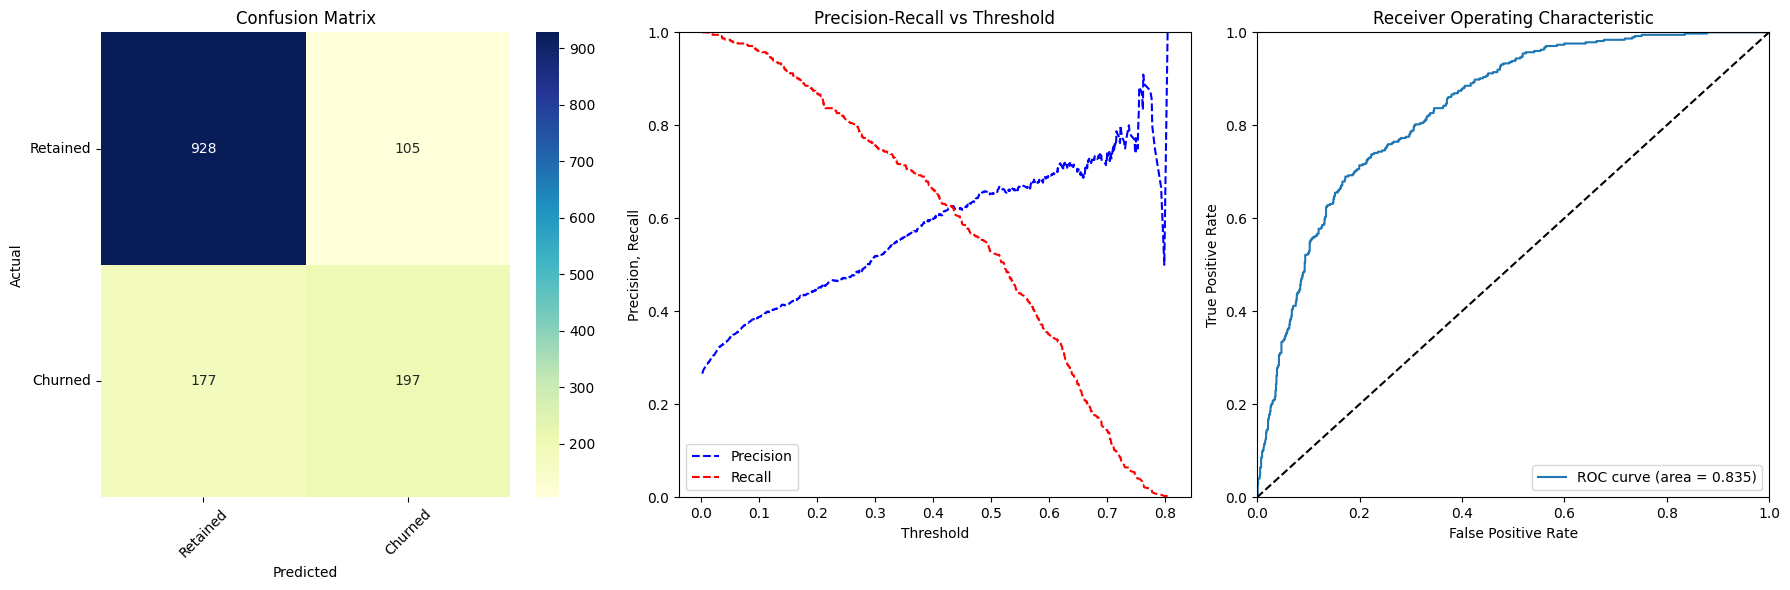

In [45]:
visualize_classification_performance(y_test, y_pred, y_proba)

##### 2a-i. Baseline polynomial features

In [ ]:
kcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
polynomial_scores = []
for d in range(1, 5):
    poly = PolynomialFeatures(degree=d)
    X_now = poly.fit_transform(X_train)
    model = lr.fit(X_now, y_train)
    scores = cross_val_score(model, X_now, y_train, scoring="f1_macro", cv=kcv, n_jobs=-1)
    polynomial_scores.append([d, np.mean(scores), np.std(scores)])

/Users/nk/Documents/projects/zc-churn-classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nk/Documents/projects/zc-churn-classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

In [73]:
for i in polynomial_scores:
    print(
        f"Degree-{i[0]} polynomial unweighted average F1 score: {i[1]:.5f}, STD: {i[2]:.5f}"  # noqa: E501
    )

Degree-1 polynomial unweighted average F1 score: 0.72792, STD: 0.01811
Degree-2 polynomial unweighted average F1 score: 0.72365, STD: 0.01762
Degree-3 polynomial unweighted average F1 score: 0.71882, STD: 0.01431
Degree-4 polynomial unweighted average F1 score: 0.42924, STD: 0.00331


Note:
- Adding polynomial features did not improve upon the base logistic regression model

### 2b. Modeling

##### Modeling pipeline helper functions:

In [ ]:
from enum import Enum


class ScoringMethod(Enum):
    """
    List of possible evaluation metric values
    """

    accuracy = "accuracy"
    f1 = "f1"
    precision = "precision"
    recall = "recall"


def calculate_score(y_true, y_pred, scoring: str) -> float:
    """
    Returns classification score, depending on the specified evaluation metric

    Args:
        y_true (_type_): Target variable true values
        y_pred (_type_): Target variable predicted values
        scoring (str): Scoring method

    Returns:
        float: Classification score
    """
    if scoring == ScoringMethod.precision.value:
        score = precision_score(y_true, y_pred)
    elif scoring == ScoringMethod.recall.value:
        score = recall_score(y_true, y_pred)
    elif scoring == ScoringMethod.f1.value:
        score = f1_score(y_true, y_pred)
    else:
        score = accuracy_score(y_true, y_pred)
    return score

In [ ]:
class DatasetManager:
    """
    Dataset manager class
    """

    def __init__(self, data: pd.DataFrame, target_column: str):
        """
        Initializes the dataset manager class to manage the train, val, test split

        Args:
            data (pd.DataFrame): Pandas dataframe
            target_column (str): Name of the target variable
        """
        self.data = data
        self.target = data[target_column]
        self.features = data.drop(columns=[target_column])

    def stratified_kfold_split(
        self, n_splits: int = 5, test_size: float = 0.2, random_state: int = 42
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, Generator]:
        """
        Performs an initial train, test split and performs another train, val split using
        scikit-learn's StratifiedKFold

        Args:
            n_splits (int, optional):
                Number of K-folds. Defaults to 5.
            test_size (float, optional):
                Indicates both validation and test set size. Defaults to 0.2.
            random_state (int, optional):
                Seed value. Defaults to 42.

        Returns:
            tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, Generator]:
                Pandas dataframes are train, test split and Generator for validation
        """
        (self.train_data, self.test_data, self.train_target, self.test_target) = (
            train_test_split(
                self.features,
                self.target,
                test_size=test_size,
                stratify=self.target,
                random_state=random_state,
            )
        )
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.splits = list(skf.split(self.train_data, self.train_target))

        return (
            self.train_data,
            self.test_data,
            self.train_target,
            self.test_target,
            self.splits,
        )

In [ ]:
class ModelTrainer:
    """
    Model training class
    """

    def __init__(
        self,
        model: Any,
        param_grid: dict,
        scoring: str = "f1",
    ):
        """
        Args:
            model (Any): Model to train.
            param_grid (dict): Hyperparameter grid.
            scoring (str, optional): _description_. Defaults to "f1".
        """
        self.model = model
        self.param_grid = param_grid
        self.scoring = scoring
        self.best_model = None
        self.best_score = -np.inf
        self.best_params = None

    def grid_search_cv(
        self,
        cv: list[tuple[np.ndarray, np.ndarray]],
        X_train: pd.DataFrame,
        y_train: pd.DataFrame,
    ) -> tuple[Any, float, dict, dict]:
        """
        Returns GridSearchCV results

        Args:
            cv (list[tuple[np.ndarray, np.ndarray]]): Stratified K-fold split indices
            X_train (pd.DataFrame): Explanatory variable values
            y_train (pd.DataFrame): Target variable values

        Returns:
            tuple[Any, float, dict, dict]: Returns the GridSearchCV results in the form of
                [
                    model object,
                    best performing hyperparameter's validation score,
                    results of all cross validation for the model,
                    best performing hyperparameter
                ]
        """
        grid_search = GridSearchCV(
            self.model, self.param_grid, cv=cv, scoring=self.scoring
        )
        grid_search.fit(X_train, y_train)
        if grid_search.best_score_ > self.best_score:
            self.best_model = grid_search.best_estimator_
            self.best_params = grid_search.best_params_
            self.best_score = grid_search.best_score_
        return self.best_model, self.best_score, grid_search.cv_results_, self.best_params

In [ ]:
class ModelPipeline:
    """
    Model training pipeline class
    """

    def __init__(
        self,
        dataset: pd.DataFrame,
        target_column: str,
        scoring: ScoringMethod = ScoringMethod.f1,
    ):
        """
        Args:
            dataset (pd.DataFrame): Dataset to split into train, val, test.
            target_column (str): Name of the target variable.
            scoring (ScoringMethod, optional):
                Evaluation metrics for model performance. Defaults to
                ScoringMethod.f1.
        """
        self.dataset_manager = DatasetManager(dataset, target_column)
        self.models = []
        self.results = {}
        self.scoring = scoring.value

    def add_model(self, model: Any, param_grid: dict | None = None):
        self.models.append((model, param_grid))

    def run_pipeline(
        self,
        n_splits: int = 5,
        test_size: float = 0.2,
    ) -> dict[str, list[Any, float, dict, dict]]:
        """
        Runs the training and stratified K-fold cross validation pipeline

        Args:
            n_splits (int, optional): Number of K-folds. Defaults to 5.
            test_size (float, optional): Validation dataset size. Defaults to 0.2.

        Returns:
            dict[str, list[Any, float, dict, dict]]: Returns the following
                {
                    Model name: [
                        model object,
                        best performing hyperparameter's validation score,
                        results of all cross validation for the model,
                        best performing hyperparameter
                        ]
                }
        """
        train_data, _, train_target, _, splits = (
            self.dataset_manager.stratified_kfold_split(
                n_splits=n_splits, test_size=test_size
            )
        )
        for model, param_grid in self.models:
            trainer = ModelTrainer(
                model=model,
                param_grid=param_grid,
                scoring=self.scoring,
            )
            model_name = type(model).__name__
            best_model, best_score, report, best_params = trainer.grid_search_cv(
                splits, train_data, train_target
            )
            self.results.setdefault(model_name, []).append(
                (best_model, best_score, report, best_params)
            )
            print(f"Model: {model_name}, {self.scoring}: {best_score}\t{best_params}")

        return self.results

    def select_best_validation_model(
        self, exclude_cv_results: bool = True
    ) -> Any | tuple[str, dict]:
        """
        Returns the model that performed the best during cross validation

        Args:
            exclude_cv_results (bool, optional): If True, returns tuple[model, CV results]

        Returns:
            Any: _description_
        """
        top_validation_model = sorted(
            self.results.items(), key=lambda x: x[1][0][1], reverse=True
        )
        best_model_name = top_validation_model[0]
        best_model = self.results[best_model_name][0][0]
        best_score = self.results[best_model_name][0][1]
        cv_results = self.results[best_model_name][0][2]
        best_params = self.results[best_model_name][0][3]

        print(f"Best Model: {best_model_name} with {self.scoring}: {best_score}")
        print(f"Best Params: {best_params}")
        if exclude_cv_results:
            return best_model
        else:
            return (best_model, cv_results)

    def predict_with_model(
        self,
        model_name: str,
        unseen_data: pd.DataFrame | None = None,
        return_proba: bool = False,
    ) -> float | tuple[float, list]:
        """
        Returns prediction of a trained model with its best performed hyperparameters.

        Args:
            model_name (str): Model.__name__ of the trained model
            unseen_data (pd.DataFrame | None, optional): If None, uses original test data.
            return_proba (bool):
                If False, only return predicted values. If True, also returns probability
        Raises:
            ValueError: if the model cannot be found

        Returns:
            float: _description_
        """
        if unseen_data is None:
            unseen_data = self.dataset_manager.test_data
        if model_name not in self.results:
            raise ValueError(f"Model {model_name} not trained")
        grid_searched_model = self.results[model_name][0][0]
        fit_model = grid_searched_model.fit(
            self.dataset_manager.train_data, self.dataset_manager.train_target
        )
        prediction = fit_model.predict(unseen_data)
        score = calculate_score(
            self.dataset_manager.test_target, prediction, self.scoring
        )
        if return_proba:
            proba = fit_model.predict_proba(unseen_data)
            return (score, proba)
        else:
            return score

    def predict_with_all_models(
        self, unseen_data: pd.DataFrame | None = None, return_proba: bool = False
    ) -> dict[str, float] | dict[str, tuple[float, list]]:
        """
        Returns predictions of the trained models with the best performing hyperparameters

        Args:
            unseen_data (pd.DataFrame | None, optional): If None, uses original test data
            return_proba (bool):
                If False, only return predicted values. If True, also returns probability
        """
        predictions = {}
        for model_name, _ in self.results.items():
            predictions[model_name] = self.predict_with_model(
                model_name=model_name, unseen_data=unseen_data, return_proba=return_proba
            )
        return predictions

    def select_best_test_model(self, unseen_data: pd.DataFrame | None = None) -> Any:
        """
        Returns the best performing model on test data, based on self.scoring method

        Args:
            unseen_data (pd.DataFrame | None, optional): If None, uses original test data
        """
        all_predictions = self.predict_with_all_models(unseen_data=unseen_data)
        best_score = -np.inf
        best_model_name = None

        for model_name, prediction_score in all_predictions.items():
            if prediction_score > best_score:
                best_score = prediction_score
                best_model_name = model_name

        folds = self.results[best_model_name]
        best_model = folds[0][0]
        best_params = folds[0][3]

        print(f"Best Model: {best_model_name} with {self.scoring}: {best_score}")
        print(f"Best Params: {best_params}")
        return best_model

    def save_instance(self, filename: str, filepath: str = "pickle_jar/"):
        """
        Save the current instance of ModelPipeline to a pickle file.

        Args:
            filepath (str): Path to save the pickled instance.
        """
        try:
            with open(filepath + filename + ".pkl", "wb") as f:
                pickle.dump(self, f)
            print(f"ModelPipeline instance saved to {filepath}")
        except Exception as e:
            print(f"Error saving ModelPipeline instance: {e}")

    @classmethod
    def load_instance(cls, filepath: str):
        """
        Load a pickled ModelPipeline instance from a file.

        Args:
            filepath (str): Path to the pickled instance.

        Returns:
            ModelPipeline: The loaded instance of ModelPipeline.
        """
        try:
            with open(filepath, "rb") as f:
                instance = pickle.load(f)
            print(f"ModelPipeline instance loaded from {filepath}")
            return instance
        except Exception as e:
            print(f"Error loading ModelPipeline instance: {e}")
            return None

##### Set up model training pipeline, to perform basic CV/hyperparameter tuning with GridSearchCV and find the best performing classifiers among:
- Logistic Regression
- Random Forest Classifier
- XGBoost Classifier
- Gaussian Naive Bayes Classifier
- MLP Classifier


In [78]:
target = "Churn_Yes"

In [ ]:
pipeline_f1 = ModelPipeline(dataset=df, target_column=target, scoring=ScoringMethod.f1)
pipeline_f1.add_model(
    LogisticRegression(),
    {
        "C": [0.1, 1, 10],
        "penalty": ["l1", "l2"],
        "max_iter": [300, 400, 500],
    },
)
pipeline_f1.add_model(
    RandomForestClassifier(),
    {
        "n_estimators": [200, 300, 400],
        "max_depth": [10, 20, 50],
        "min_samples_split": [5, 10, 20],
        "max_features": ["sqrt", "log2"],
    },
)
pipeline_f1.add_model(
    XGBClassifier(use_label_encoder=False),
    {
        "n_estimators": [200, 300, 400],
        "learning_rate": [0.3, 0.5, 0.9],
        "max_depth": [5, 10, 15],
        "subsample": [0.3, 0.5, 0.7],
        "colsample_bytree": [0.3, 0.5, 0.7],
        "gamma": [1, 10, 100],
        "lambda": [0.001, 0.01, 1],
        "early_stoppping_rounds": [5, 10],
        "eval_metric": ["logloss", "aucpr"],
    },
)
pipeline_f1.add_model(GaussianNB(), {"var_smoothing": [1e-9, 1e-8, 1e-7]})
pipeline_f1.add_model(
    MLPClassifier(),
    {
        "hidden_layer_sizes": [(50, 50), (100, 50, 25)],
        "activation": ["relu", "logistic"],
        "solver": ["adam", "sgd"],
        "alpha": [1e-5, 1e-4, 1e-3],
        "max_iter": [200, 300, 400],
    },
)

In [83]:
f1_results = pipeline_f1.run_pipeline(n_splits=5, test_size=0.2)

Model: LogisticRegression, f1: 0.5880014520462757	{'C': 1, 'max_iter': 400, 'penalty': 'l2'}
Model: RandomForestClassifier, f1: 0.5665215302167935	{'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 300}
Model: XGBClassifier, f1: 0.5995454616405028	{'colsample_bytree': 0.5, 'early_stoppping_rounds': 5, 'eval_metric': 'logloss', 'gamma': 10, 'lambda': 0.01, 'learning_rate': 0.9, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
Model: GaussianNB, f1: 0.6195471112246107	{'var_smoothing': 1e-08}
Model: MLPClassifier, f1: 0.5755007073372017	{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 25), 'max_iter': 300, 'solver': 'adam'}


Checking for overfitting - Cross validation scores seem to be fairly stable

In [ ]:
pd.DataFrame(pipeline_f1.results["XGBClassifier"][0][2]).sort_values(
    "mean_test_score", ascending=False
).std_test_score.head()

3334   0.024
2146   0.024
3442   0.024
2038   0.024
4621   0.024
Name: std_test_score, dtype: float64

In [ ]:
pd.DataFrame(pipeline_f1.results["GaussianNB"][0][2]).sort_values(
    "mean_test_score", ascending=False
).std_test_score.head()

1   0.017
0   0.015
2   0.020
Name: std_test_score, dtype: float64

In [183]:
test_results = {}
train_data = pipeline_f1.dataset_manager.train_data
train_target = pipeline_f1.dataset_manager.train_target
test_data = pipeline_f1.dataset_manager.test_data
test_target = pipeline_f1.dataset_manager.test_target
for k, v in pipeline_f1.results.items():
    model = v[0][0]
    model.fit(train_data, train_target)
    preds = model.predict(test_data)
    pred_proba = model.predict_proba(test_data)
    scores = f1_score(test_target, preds)
    test_results[k] = (preds, pred_proba, scores)

<generator object <genexpr> at 0x28db297e0>

LogisticRegression 0.60


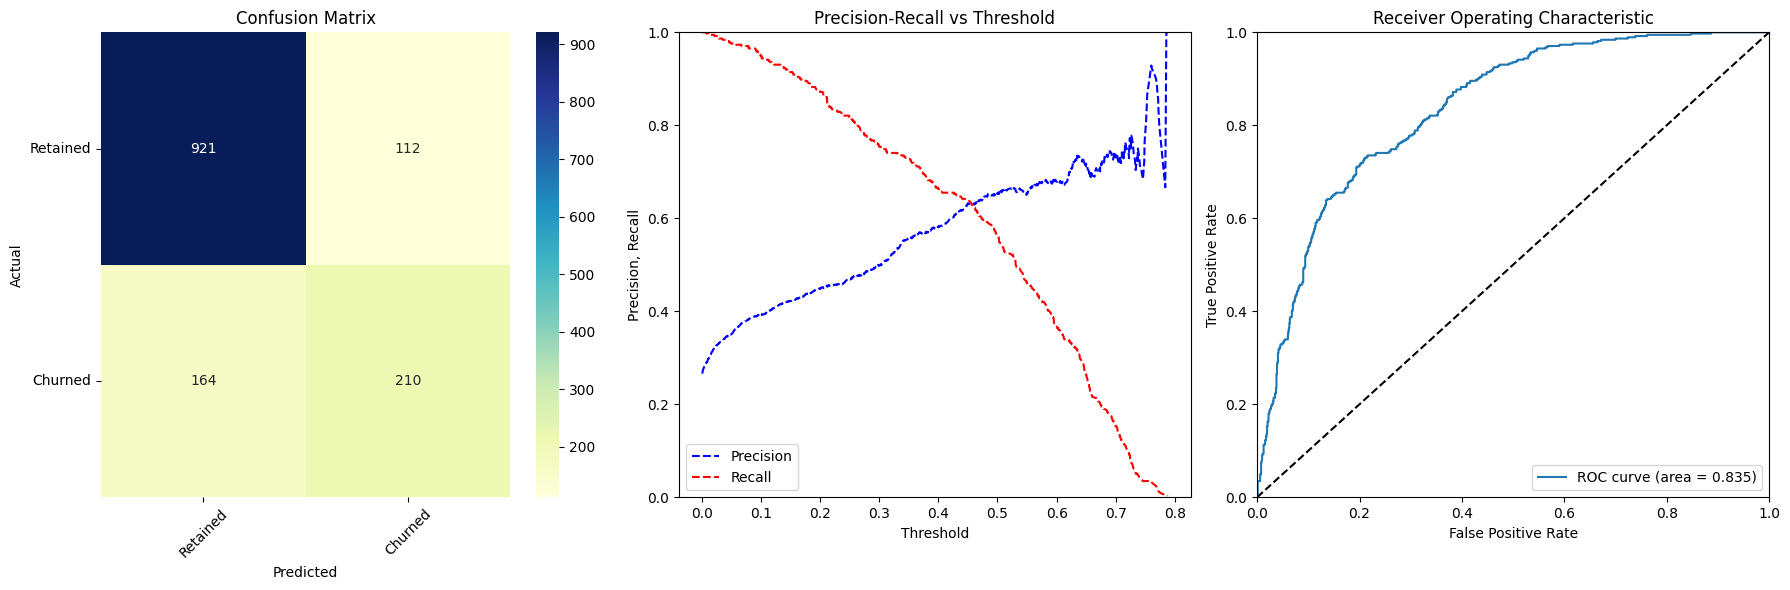

RandomForestClassifier 0.57


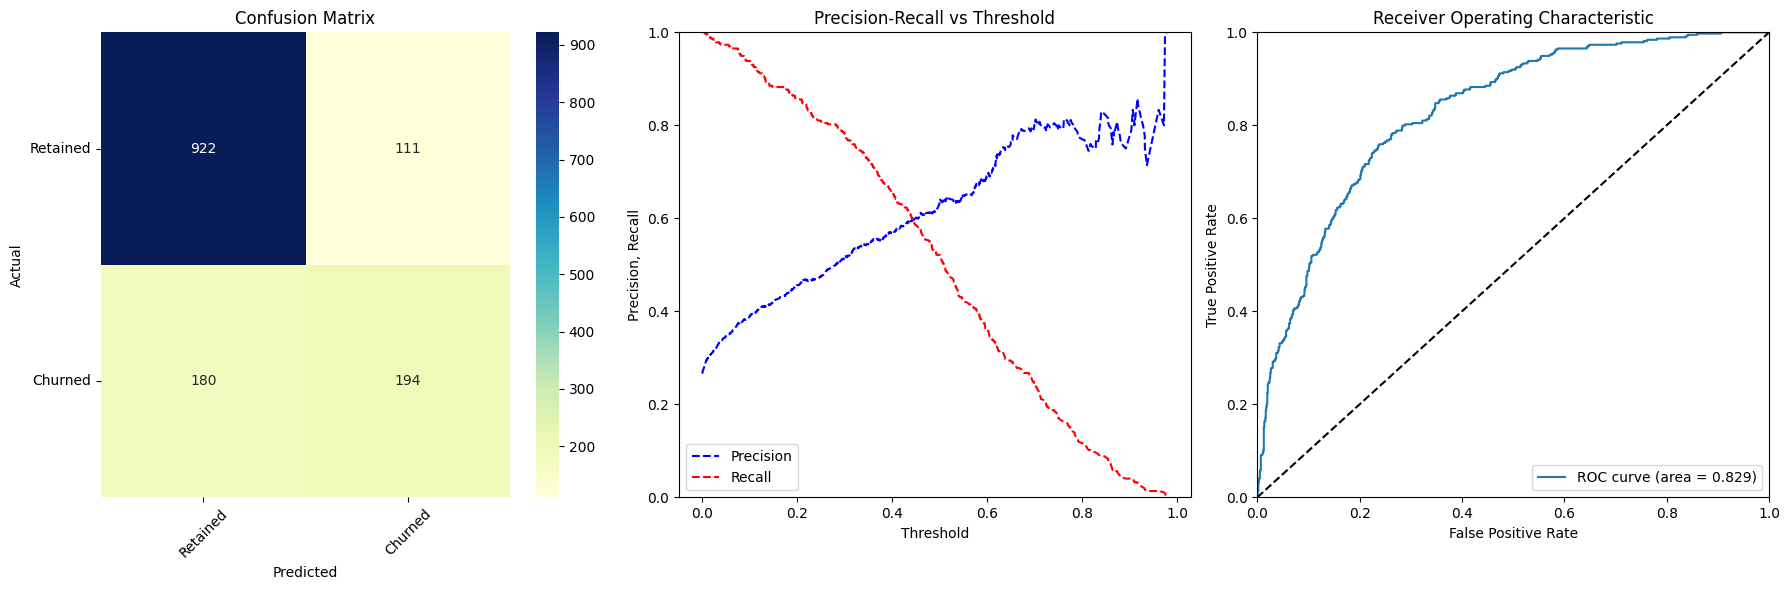

XGBClassifier 0.61


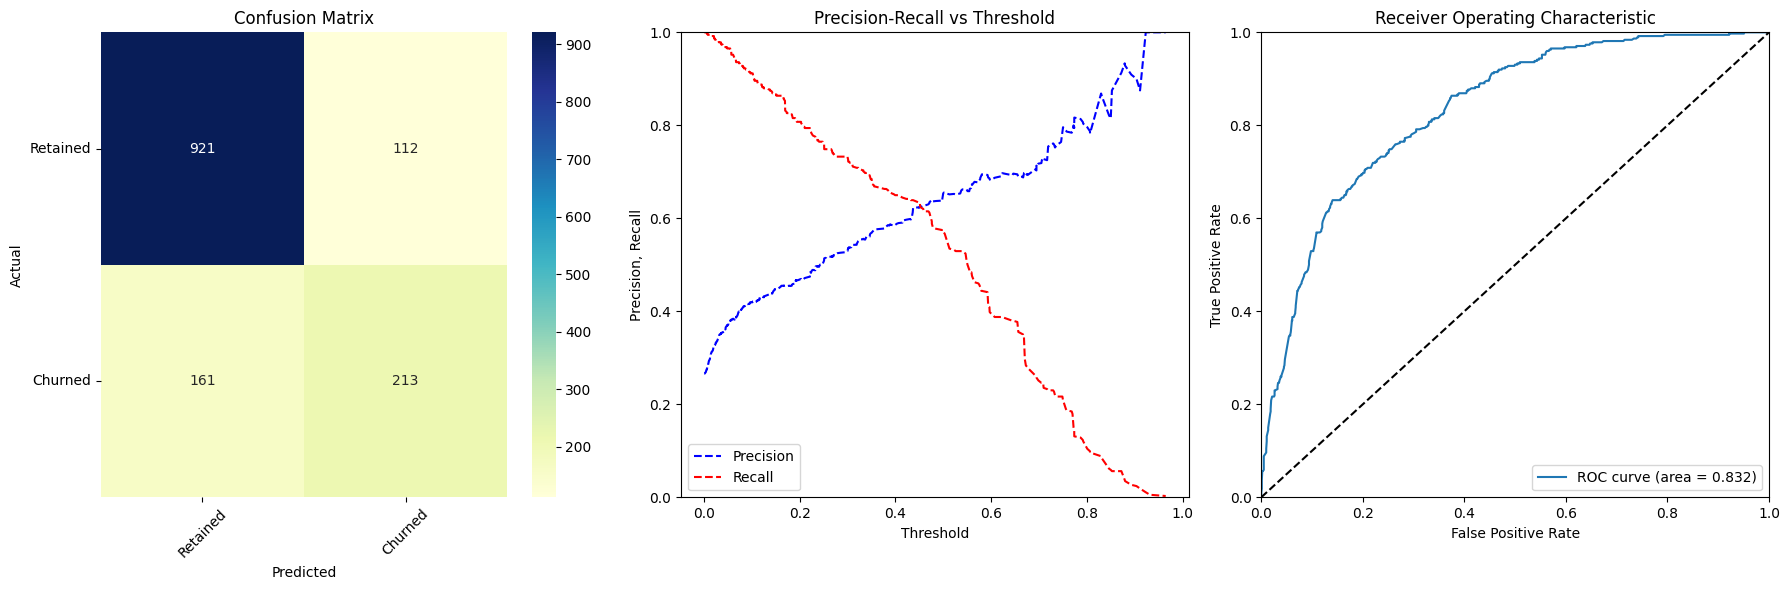

GaussianNB 0.60


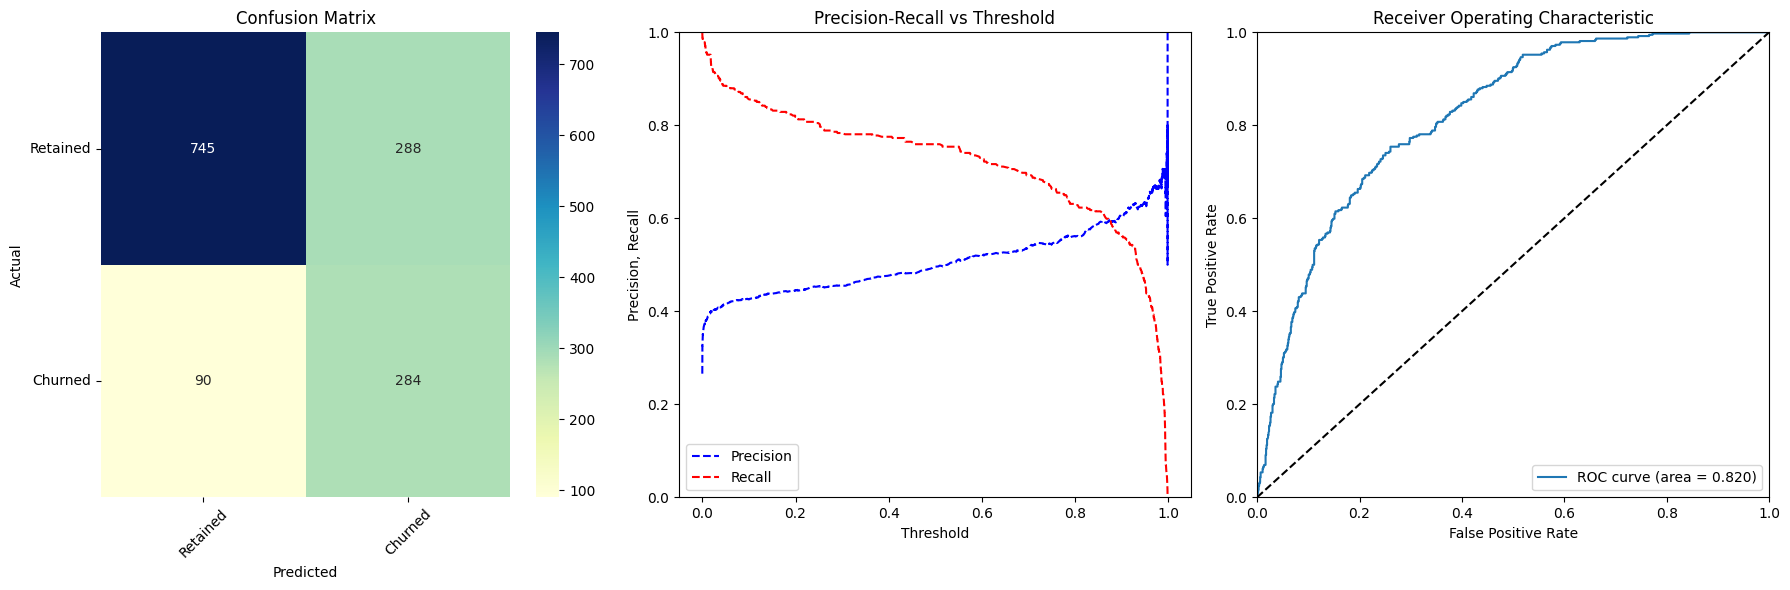

MLPClassifier 0.58


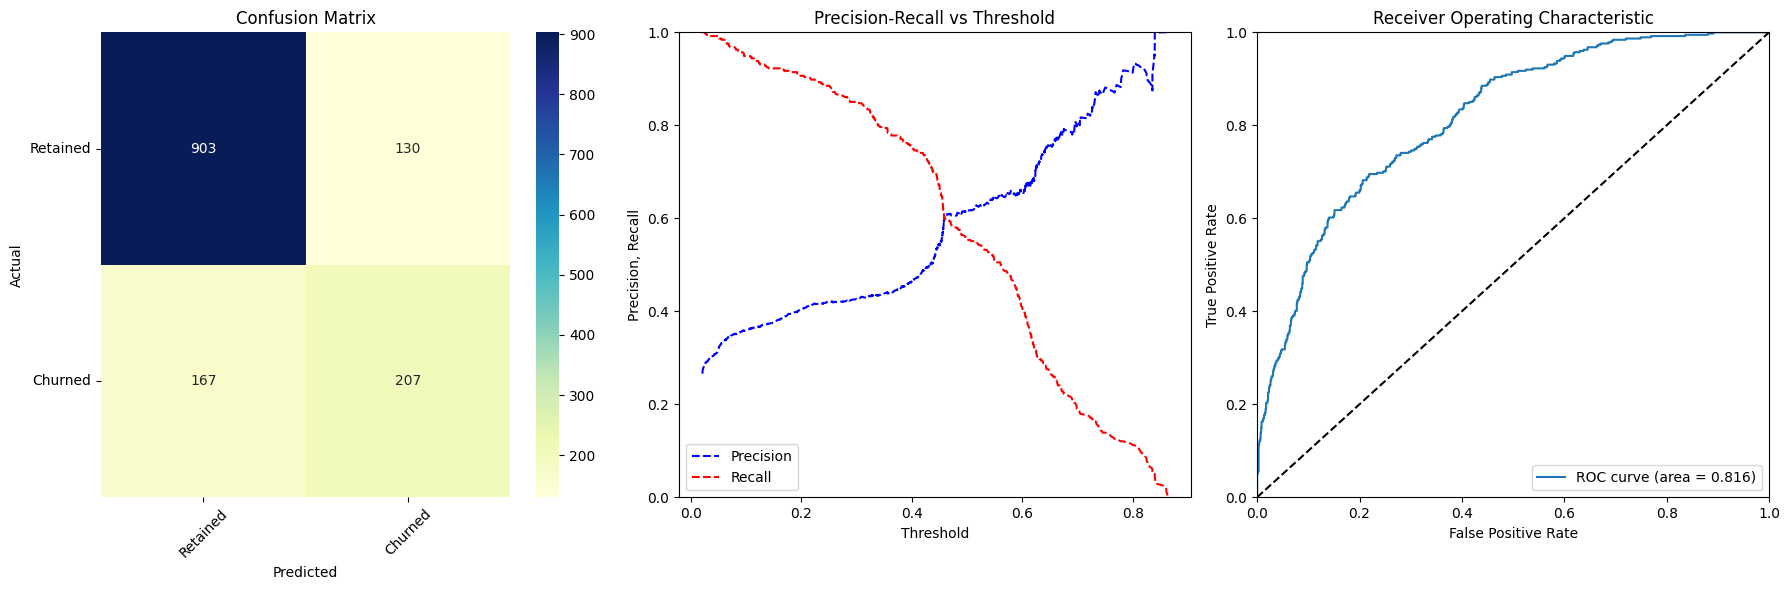

In [193]:
for k, v in test_results.items():
    print(k, f"{v[2]:.2f}")
    visualize_classification_performance(test_target, v[0], v[1])

Note:
- Some models were able to improve the classification performance from the baseline model (F1 score of the Churned class 0.58), notably Gaussian Naive Bayes, Logistic Regression and XGBClassifer

- Also noting that the Gaussian Naive Bayes had high true positives at the expense of false positives, relative to the other two models

##### Ensemble of the models to improve the results

In [ ]:
from sklearn.ensemble import VotingClassifier

xgb = pipeline_f1.results["XGBClassifier"][0][0]
gnb = pipeline_f1.results["GaussianNB"][0][0]
mlp = pipeline_f1.results["MLPClassifier"][0][0]
lr = pipeline_f1.results["LogisticRegression"][0][0]
rf = pipeline_f1.results["RandomForestClassifier"][0][0]

In [ ]:
voting_all = VotingClassifier(
    estimators=[("xgb", xgb), ("gnb", gnb), ("mlp", mlp), ("lr", lr), ("rf", rf)],
    voting="soft",
)

In [ ]:
voting_all.fit(X_train, y_train)
predictions = voting_all.predict(X_test)
pred_proba = voting_all.predict_proba(X_test)

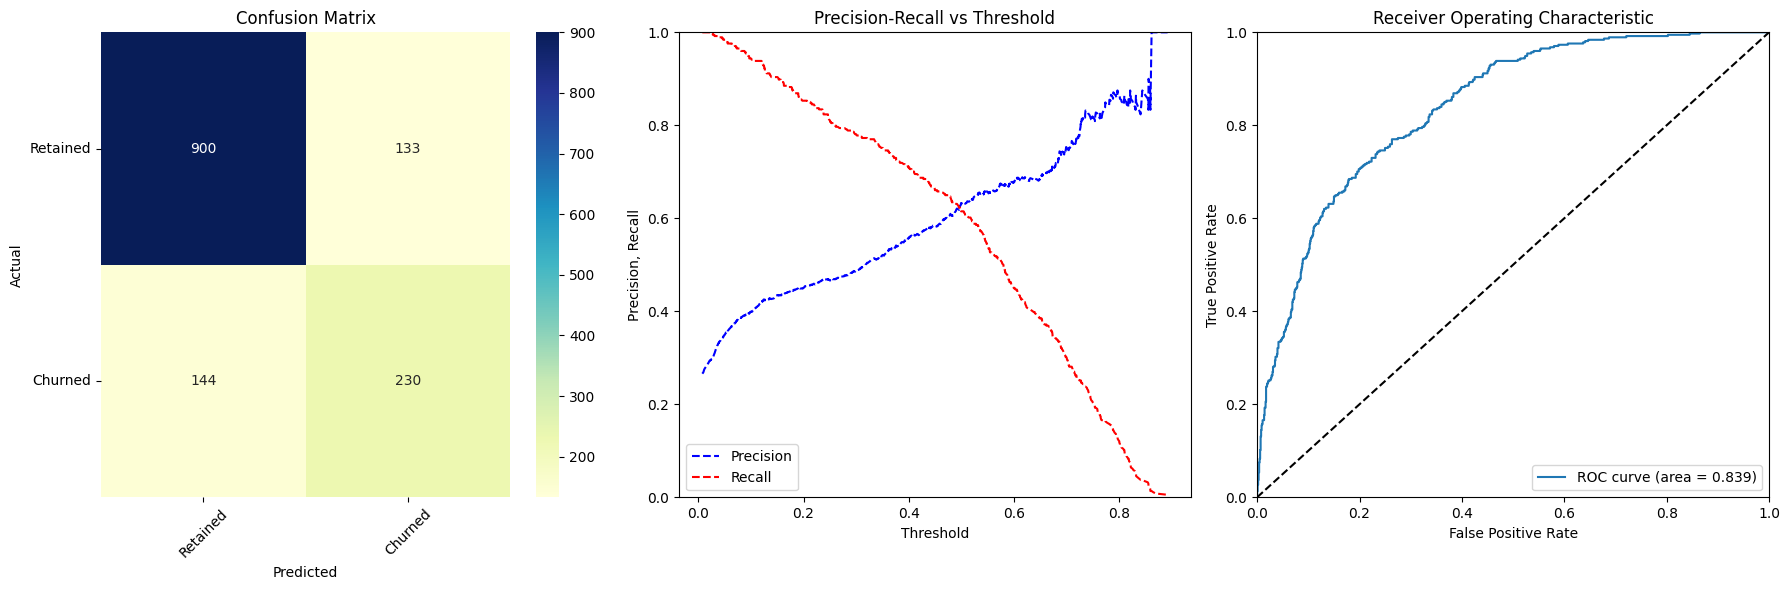

In [ ]:
visualize_classification_performance(y_test, predictions, pred_proba)

In [ ]:
f1_score(y_test, predictions)

0.6241519674355496

In [ ]:
voting_best = VotingClassifier(
    estimators=[("xgb", xgb), ("gnb", gnb), ("lr", lr)], voting="soft"
)
X_train = pipeline_f1.dataset_manager.train_data
y_train = pipeline_f1.dataset_manager.train_target
y_test = pipeline_f1.dataset_manager.test_target
voting_best.fit(X_train, y_train)
predictions = voting_best.predict(X_test)
pred_proba = voting_best.predict_proba(X_test)

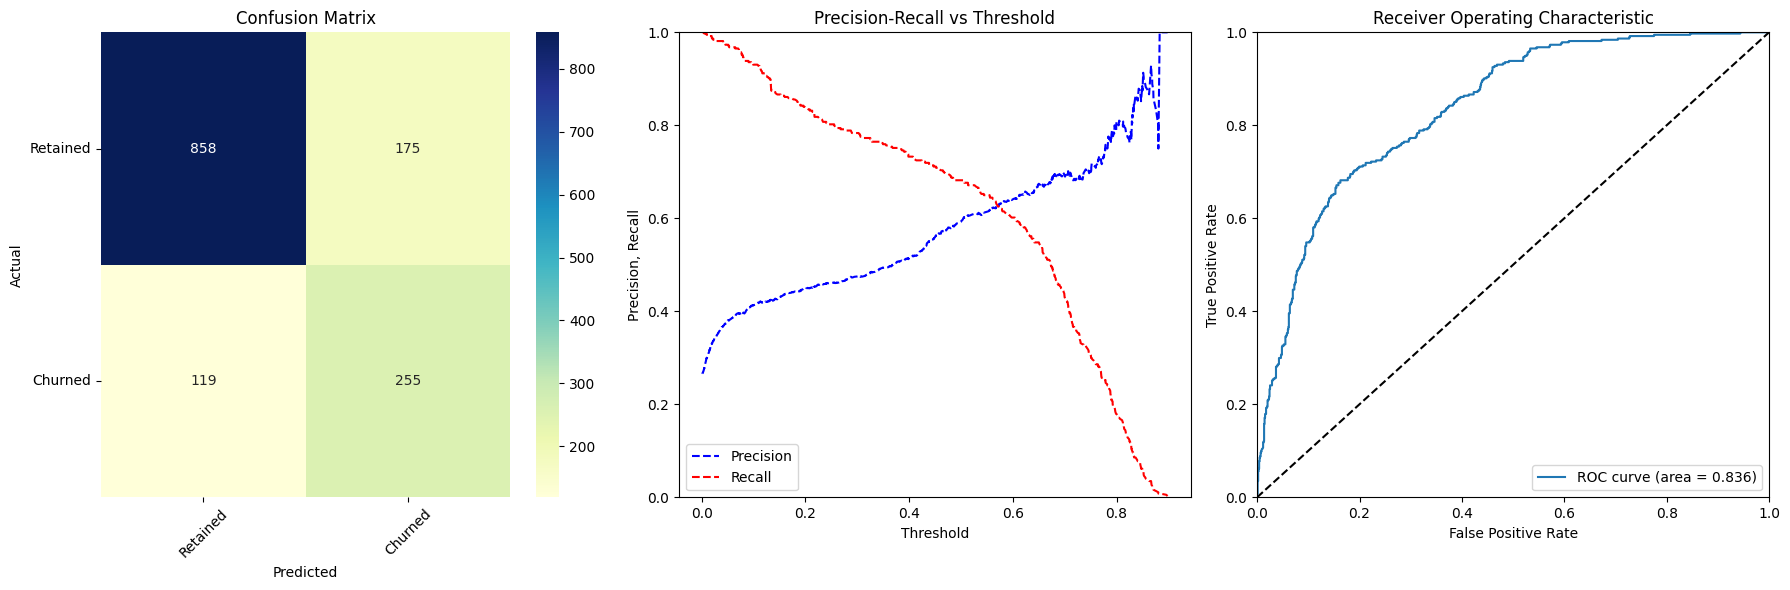

In [197]:
visualize_classification_performance(y_test, predictions, pred_proba)

In [ ]:
print(
    f"Final model F1 score for the Churned class is:\t{f1_score(y_test, predictions):.2f}"
)  # noqa: E501
print(
    f"Final model F1 unweighted average score is:\t{f1_score(y_test, predictions, average='macro'):.2f}"
)  # noqa: E501

Final model F1 score for the Churned class is:	0.63
Final model F1 unweighted average score is:	0.74


Note:

- Final model using soft voting among the better performing models - GaussianNB, XGBClassifier, and LogisicRegression - was able to improve upon the baseline model by c. 5pp

- The notebook will end here, but there are additional steps that can be taken to try to improve the models, including
    - Different feature selection and feature engineering
    - Continue hyperparameter tuning
    - Employ additional ML models